In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from itertools import chain, combinations
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

In [3]:
df_original = pd.read_csv("telco_churn_clean_feature_eng.csv")

In [4]:
df = df_original.copy()
df.drop("Churn Reason", axis=1, inplace=True)

In [5]:
categorical_columns = []
binary_columns = []
for col in df.columns:
    if (df[col].dtype == "O") & (df[col].nunique() > 2):
        categorical_columns.append(col)
    if (df[col].dtype == "O") & (df[col].nunique() == 2):
        binary_columns.append(col)

In [6]:
for col in binary_columns:
    df[col] = np.where(df[col].isin(["Yes", "Positive"]), 1, 0)
df = pd.get_dummies(df, columns=categorical_columns)

### Model to extract features importance

##### Hyperparameter tuning

In [ ]:
X = df.drop(["Churn Value"], axis=1)
y = df["Churn Value"]

scaler = MinMaxScaler()
X["Monthly Charges"] = scaler.fit_transform(X[["Monthly Charges"]])
X["Total Charges"] = scaler.fit_transform(X[["Total Charges"]])
X["Tenure Months"] = scaler.fit_transform(X[["Tenure Months"]])

parameters = {"n_estimators": [150,180,200,220,240],
              'min_child_weight': [1,2,3,4,5,6],
              'gamma': [1,2,3,4,5,6,7],
              'subsample': [0.9,1.0],
              'colsample_bytree': [0.7, 0.8, 0.9],
              'max_depth': [1,2,3,4,5]}

xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False)
model = GridSearchCV(xgb, parameters, scoring="recall", cv=5)

model.fit(X, y)

KeyboardInterrupt: 

In [7]:
best_params ={'colsample_bytree': 0.8,
              'gamma': 4,
              'max_depth': 3,
              'min_child_weight': 3,
              'n_estimators': 220,
              'subsample': 1.0}

In [8]:
X = df.drop(["Churn Value"], axis=1)
y = df["Churn Value"]

scaler = MinMaxScaler()
X["Monthly Charges"] = scaler.fit_transform(X[["Monthly Charges"]])
X["Total Charges"] = scaler.fit_transform(X[["Total Charges"]])
X["Tenure Months"] = scaler.fit_transform(X[["Tenure Months"]])

xgb = XGBClassifier(**best_params, eval_metric="logloss", use_label_encoder=False)
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=4, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=220, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

<BarContainer object of 36 artists>

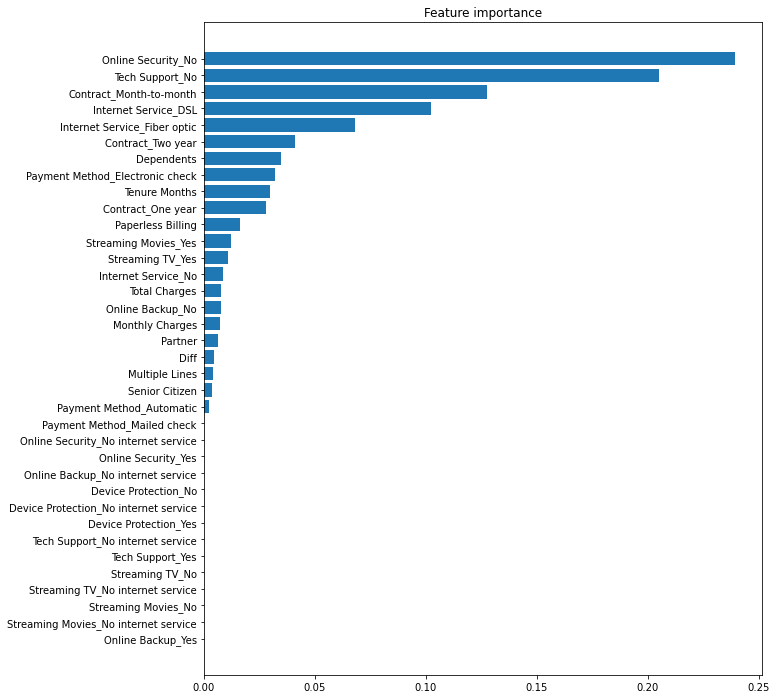

In [9]:
imp = pd.Series(data=xgb.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
plt.barh(y=imp.index, width=imp.values)

In [10]:
important_features = list(imp[imp>0].index)

In [11]:
important_features

['Payment Method_Automatic',
 'Senior Citizen',
 'Multiple Lines',
 'Diff',
 'Partner',
 'Monthly Charges',
 'Online Backup_No',
 'Total Charges',
 'Internet Service_No',
 'Streaming TV_Yes',
 'Streaming Movies_Yes',
 'Paperless Billing',
 'Contract_One year',
 'Tenure Months',
 'Payment Method_Electronic check',
 'Dependents',
 'Contract_Two year',
 'Internet Service_Fiber optic',
 'Internet Service_DSL',
 'Contract_Month-to-month',
 'Tech Support_No',
 'Online Security_No']

#### Select final predictors

In [12]:
results = {}
for i in range(len(important_features)-1):
    
    predictors = important_features[i:]
    
    X = df.drop(["Churn Value"], axis=1)
    y = df["Churn Value"]

    scaler = MinMaxScaler()
    X["Monthly Charges"] = scaler.fit_transform(X[["Monthly Charges"]])
    X["Total Charges"] = scaler.fit_transform(X[["Total Charges"]])
    X["Tenure Months"] = scaler.fit_transform(X[["Tenure Months"]])
    
    X = X[predictors]

    xgb = XGBClassifier(**best_params, eval_metric="logloss", use_label_encoder=False)
    score = cross_val_score(xgb, X, y, scoring="recall", cv=5)
    results[i] = (score.mean(), score.std())

In [13]:
top_n_predictors = 0
best_score = 0
for k, v in results.items():
    if v[0] >= best_score:
        best_score = v[0]
        top_n_predictors = k

In [14]:
best_predictors = important_features[top_n_predictors:]
best_predictors

['Contract_Month-to-month', 'Tech Support_No', 'Online Security_No']

#### Hyperparameter tuning for final model

In [40]:
X = df.drop(["Churn Value"], axis=1)
y = df["Churn Value"]

X = X[best_predictors]

parameters = {"n_estimators": [150,180,200,220,240],
              'min_child_weight': [1,2,3,4,5,6],
              'gamma': [1,2,3,4,5,6,7],
              'subsample': [0.9,1.0],
              'colsample_bytree': [0.7, 0.8, 0.9],
              'max_depth': [1,2,3,4,5]}

xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False)
model = GridSearchCV(xgb, parameters, scoring="recall", cv=5)

model.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=False,
                    

In [44]:
best_params = model.best_params_
best_params

{'colsample_bytree': 0.7,
 'gamma': 1,
 'max_depth': 1,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 0.9}

In [42]:
xgb = XGBClassifier(**best_params, eval_metric="logloss", use_label_encoder=False)
recall = cross_val_score(xgb, X, y, scoring="recall", cv=5)
accuracy = cross_val_score(xgb, X, y, scoring="accuracy", cv=5)
precision = cross_val_score(xgb, X, y, scoring="precision", cv=5)

print("Final model metrics")
print("Acuracy: ", accuracy.mean()*100)
print("Recall: ", recall.mean()*100)
print("Precision: ", precision.mean()*100)

Final model metrics
Acuracy:  76.33656549603133
Recall:  63.40238849622229
Precision:  54.73574513986773
